<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/ResNet20v1_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# Which GPU?
!nvidia-smi

Tue Jul 14 08:00:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

--2020-07-14 08:00:05--  https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6064 (5.9K) [text/plain]
Saving to: ‘resnet_cifar10.py’

resnet_cifar10.py   100%[===================>]   5.92K  --.-KB/s    in 0s      

2020-07-14 08:00:05 (53.1 MB/s) - ‘resnet_cifar10.py’ saved [6064/6064]



In [4]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import tensorflow as tf
import resnet_cifar10
import numpy as np
import time

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [5]:
def get_training_model():
    # ResNet20
    n = 2
    depth =  n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = Input(shape=(32, 32, 3))

    # The Stem Convolution Group
    x = resnet_cifar10.stem(inputs)

    # The learner
    x = resnet_cifar10.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet_cifar10.classifier(x, 10)

    # Instantiate the Model
    model = Model(inputs, outputs)
    
    return model

In [6]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	with plt.xkcd():
		plt.figure()
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [7]:
# Load the training set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [8]:
BATCH_SIZE = 128

def normalize(image, label):
    return tf.image.convert_image_dtype(image, tf.float32), label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [9]:
model = get_training_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 32, 32, 16)   64          conv2d_166[0][0]                 
__________________________________________________________________________________________________
re_lu_164 (ReLU)                (None, 32, 32, 16)   0           batch_normalization_164[0][0]    
____________________________________________________________________________________________

In [69]:
# Custom LR schedule as mentioned in the LossLandscape paper
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1.6*1e-3),
    (9, (1.6*1e-3)/2),
    (19, (1.6*1e-3)/4),
    (29, (1.6*1e-3)/8),
]

def lr_schedule(epoch):
    if (epoch >= 0) & (epoch < 9):
        return LR_SCHEDULE[0][1]
    elif (epoch >= 9) & (epoch < 19):
        return LR_SCHEDULE[1][1]
    elif (epoch >= 19) & (epoch < 29):
        return LR_SCHEDULE[2][1]
    else:
        return LR_SCHEDULE[3][1]

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

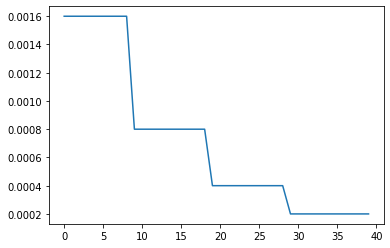

In [70]:
plt.plot([lr_schedule(x) for x in rng])
plt.show()


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 1/40
391/391 [==============================] - 47s 119ms/step - loss: 1.3315 - accuracy: 0.5166 - val_loss: 1.5193 - val_accuracy: 0.4933 - lr: 0.0016

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 2/40
391/391 [==============================] - 46s 118ms/step - loss: 0.9361 - accuracy: 0.6697 - val_loss: 1.3517 - val_accuracy: 0.5490 - lr: 0.0016

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 3/40
391/391 [==============================] - 46s 118ms/step - loss: 0.7493 - accuracy: 0.7366 - val_loss: 1.1005 - val_accuracy: 0.6303 - lr: 0.0016

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 4/40
391/391 [==============================] - 46s 118ms/step - loss: 0.6130 - accuracy: 0.7872 - val_loss: 1.1103 - val_accuracy: 0.6566 - lr: 0.0016

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 5/40
391/391

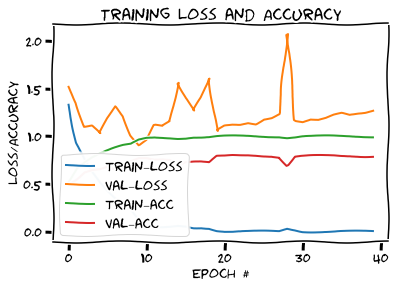

In [71]:
# Train model
model = get_training_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=40,
         callbacks=[lr_callback])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(h)

In [72]:
# Serialize the model
model.save('resnet20v1_cifar10_40epochs.h5')

In [73]:
# Adding data augmentation
def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 1/40
391/391 [==============================] - 47s 119ms/step - loss: 1.6023 - accuracy: 0.4100 - val_loss: 1.7511 - val_accuracy: 0.4241 - lr: 0.0016

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 2/40
391/391 [==============================] - 46s 118ms/step - loss: 1.2054 - accuracy: 0.5667 - val_loss: 1.2724 - val_accuracy: 0.5724 - lr: 0.0016

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 3/40
391/391 [==============================] - 46s 119ms/step - loss: 1.0296 - accuracy: 0.6324 - val_loss: 1.0796 - val_accuracy: 0.6244 - lr: 0.0016

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 4/40
391/391 [==============================] - 46s 118ms/step - loss: 0.9027 - accuracy: 0.6799 - val_loss: 0.9315 - val_accuracy: 0.6671 - lr: 0.0016

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 5/40
391/391

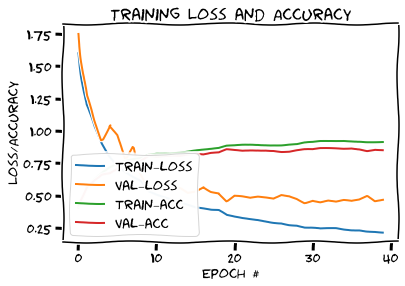

In [74]:
# Train model
model = get_training_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=40,
         callbacks=[lr_callback])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(h)

In [75]:
# Serialize the model
model.save('resnet20v1_cifar10_40epochs_data_aug.h5')

Put the model weights in a GCS bucket. 

In [76]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [79]:
!gsutil -m cp -r *.h5 gs://losslandscape

Copying file://resnet20v1_cifar10_40epochs_data_aug.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1_cifar10_40epochs.h5 [Content-Type=application/octet-stream]...
\ [2/2 files][ 13.9 MiB/ 13.9 MiB] 100% Done                                    
Operation completed over 2 objects/13.9 MiB.                                     
